<h1 style="text-align: center;">CNN Segmentation - Neural Network</h1>
<h3 style="text-align: center;">Carlos Moreno</h3>

In [7]:
import os
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import glob
import cv2
import pickle

Run device

In [ ]:
if torch.cuda.is_available(): 
    dev = "cuda" 
else: 
    dev = "cpu" 
device = torch.device("cpu")
print(torch.cuda.get_device_name())

->Load Dataset

In [25]:
def Set_dataset(path, SIZE):
    img_list = []
    with Image.open(path) as img:
        try:
            while True:
                img_rgb = img.convert("RGB")
                img_resized = img_rgb.resize((SIZE, SIZE))
                img_array = np.array(img_resized)
                img_list.append(img_array)
                img.seek(img.tell() + 1)  # Move to the next page
        except EOFError:
            pass  
    return img_list

In [ ]:
training_ds = Set_dataset("..\\Database\\EPFL\\training.tif", 512)
training_mask_ds = Set_dataset("..\\Database\\EPFL\\training.tif", 512)
test_ds = Set_dataset("..\\Database\\EPFL\\training.tif", 512)
test_mask_ds = Set_dataset("..\\Database\\EPFL\\training.tif", 512) 

In [ ]:
training_img = []
SIZE = 512

with Image.open("..\\Database\\EPFL\\training.tif") as img:
    try:
        while True:
            img_rgb = img.convert("RGB")
            img_resized = img_rgb.resize((SIZE, SIZE))
            img_array = np.array(img_resized)
            training_img.append(img_array)
            img.seek(img.tell() + 1)  # Move to the next page
    except EOFError:
        pass  

training_img = np.array(training_img)

print(f"Loaded {len(training_img)} images from the TIFF file."), training_img[1].shape

Clase Dataset (Inicializa los datos y los reordena)

In [ ]:
class MainDataset(Dataset):
    def __init__(self, filepath):
        self.x, self.y = torch.load(filepath) #Upload ·· x - Number, y - Labels
        self.x = self.x / 255. #Normalizamos
        self.y = F.one_hot(self.y, num_classes=10).to(float) # Enconder para clasificación por vectores
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, ix): 
        return self.x[ix], self.y[ix] # i-ésimo numero, label iésima

In [ ]:
train_ds = MainDataset('Database\\MNIST\\processed\\training.pt')
test_ds = MainDataset('..\\Database\\MNIST\\processed\\test.pt')

In [ ]:
train_dl = DataLoader(train_ds, batch_size=5) # se divide el dataset en batch de a 5
test_dl = DataLoader(test_ds, batch_size=5) # se divide el dataset en batch de a 5

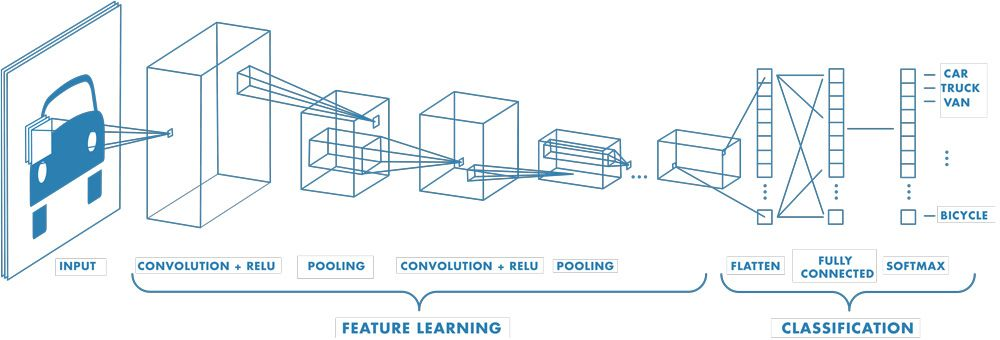